**Ethan, Alice, and Cole**

Spring 2020

CS443: Computational Neuroscience

Project 2: Content Addressable Memory

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import preprocessing
from PIL import Image as im

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3) Hopfield network

In this task, you will implement and analyze a Hopfield network — a recurrent neural network with content addressable memory. You will use Hebbian learning learn weights that imprint the training data as "memories" that can be recalled with an incomplete and/or distorted version of the training data.

### 3a. Load in image data

- Load in the training set, three color photographs of natural scenes with varying resolution: `train_img_1.png`, `train_img_2.png`, and `train_img_3.png`.
    - *Note that the docstrings/test code in the next tasks assumes that you load in the images as PIL Image objects. You may deviate from this if you prefer a different way to handle this, but note that your binarized feature vectors should look reasonable at the end of Task 3c and be consistent with the shape/type/value test code there.*

In [65]:
img1 = im.open("data/train_img_1.png")
img2 = im.open("data/train_img_2.png")
img3 = im.open("data/train_img_3.png")

### 3b. Consistently resize images

Right now, your images have different spatial resolutions. You should resize them so that they are 128x128 grayscale images.

- In `preprocessing.py`, implement `resize_imgs`.
- Resize the training images below to make them consistently sized and grayscale so that they can be placed in a single ndarray (`shape=(3, 128, 128)`).
- Write code inside `row_plot` below then create a 1x3 row showing all the images side-by-side.

In [66]:
imgs = preprocessing.resize_imgs([img1, img2, img3], 128, 128)
print(imgs.shape)

(3, 128, 128)


In [67]:
def row_plot(imgs, title, cmap='bone', sz=(12, 4)):
    '''Plots images in `imgs` in a single row
        
    Parameters:
    -----------
    imgs: ndarray. shape=(N, Iy, Ix)
        Images to display in the row.
    title: str. Title for entire figure.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the figure size and color scheme.
    - Label each image with its index in `imgs` (e.g. 0, 1, 2)
    '''
    
    fig = plt.figure(figsize= sz)
    fig.suptitle(title)
    a = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(imgs[0], cmap = cmap)
    a.set_title('Index: 0')
    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(imgs[1], cmap = cmap)
    a.set_title('Index: 1')
    a = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(imgs[2], cmap = cmap)
    a.set_title('Index: 2')

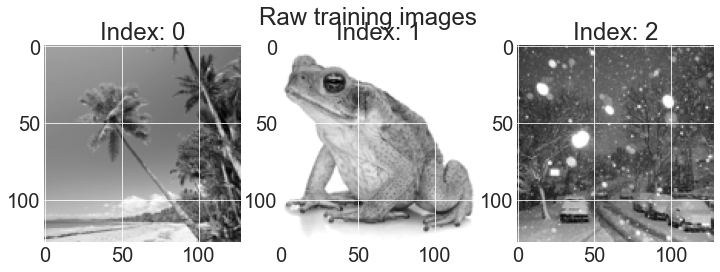

In [68]:
row_plot(imgs, 'Raw training images', cmap='gray')

### 3c. Preprocess images into bipolar feature vectors

Hopfield networks assume that inputs are 1D feature vectors of binary values. In this subtask, you will do the preprocessing to get the images encoded as binary feature vectors. While this can be done by representing values as `[0, 1]`, it is more common to use **bipolar vectors** with either [-1, +1] components. *One extension idea is to investigate why bipolar vectors are preferred over ordinary 0/1 binary.*

For example, before training a Hopfield network, you might flatten and binarize an image, then encode its pixel values as `[-1, +1, -1, -1, -1,...]`.

In `preprocessing.py`, implement the following functions:
- `img2binaryvectors`: Converts grayscale images into bipolar feature vectors.
- `vec2img`: Inflates a binary feature vector back into its (width, height) dimensions so that it can be plotted/visualized.
- In the cell below, show your preprocessed binary images in a row.

In [69]:
# Preprocess here
imgs_pp = preprocessing.img2binaryvectors(imgs) 
print(f'After preprocessing, image data shape: {imgs_pp.shape}, dtype: {imgs_pp.dtype}, Unique values: {np.unique(imgs_pp)}')
print('You should see:\nAfter preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]')

After preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  0  1]
You should see:
After preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]


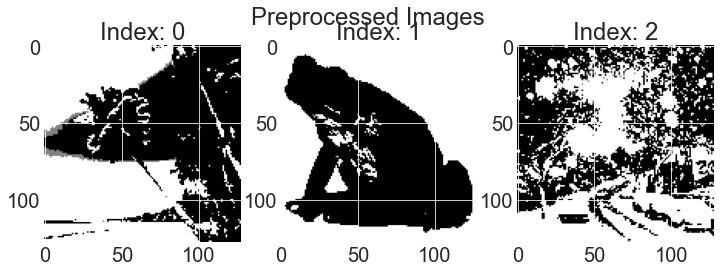

In [70]:
# Plot here
imgs = preprocessing.vec2img(imgs_pp,128, 128)
row_plot(imgs, 'Preprocessed Images', cmap='gray')

### 3d. Implement and train your Hopfield net. Use it to recall training images.

Implement the following methods in `hopfield.py`. Note that there is test code below.
- Constructor: Initializes things, including the weights via `initialize_wts`.
- `initialize_wts`: Use Hebbian learning to generate each neuron's connectivity weights based on all the training data. The Hebbian weight equation is: $$w_{n,m} = \sum_{i=1}^N \vec{I}_{i}^T \vec{I}_{i}$$ where $i$ indexes the $i^{th}$ 1D input feature vector $I$. This equation holds if $i \neq j$. If $i = j$, then $w_{n,m} = 0$ (along main diagonal).
- `energy`: Compute the energy of the current state of the network: $$E = -\frac{1}{2} \sum_{n} \sum_{m} y_n w_{n,m} y_m$$ where $\vec{y}$ is the 1D `net_act` at each index $n$ and $m$ and $w_{n,m}$ is the weight between the corresponding neurons.
- `predict`: Use test images to have the network generate (recall) the 'closest' image in memory (from training set). In this subtask, the test set is the training set (i.e. prompt recall of a memory with the memory). Activation of neurons is done **asychronously** — the `net_act` of only a random subset of neurons are updated at each time step. Equation for updating the `net_act` at each time step $t$:
$$y_{i}(t) = \text{sgn} \left ( \sum_{j=1}^M w_{ij}y_j \right )$$
Above, $\text{sgn} (x)$ is the sign function (+1 if $x > 0$, 0 if $x = 0$, -1 if $x < 0$), $i$ are all indices in the list `inds` of randomly selected neurons to update on timestep $t$.

In [71]:
from hopfield import HopfieldNet

#### Test constructor and `initialize_wts`

In the cell below:
- Create a Hopfield net and train it on the N=3 training images.
- Check your weights with the test code below.

##### (i) Random pattern test

In [72]:
np.random.seed(0)
test_rand_n, test_rand_m = 3, 4
rand_data = np.random.random(size=(test_rand_n, test_rand_m))
rand_net = HopfieldNet(rand_data, orig_width=2, orig_height=2)
print(f'Your weights are:\n{rand_net.wts} and should be:')
print('[[0.    0.345 0.426 0.396]\n [0.345 0.    0.339 0.389]\n [0.426 0.339 0.    0.379]\n [0.396 0.389 0.379 0.   ]]')

data shape (3, 4)
data shape (3, 4)
self.neurons 4
wts shape (4, 4)
[[0.549 0.715 0.603 0.545]]
[[0.424 0.646 0.438 0.892]]
[[0.964 0.383 0.792 0.529]]
unique [0.    0.339 0.345 0.379 0.389 0.396 0.426] 
counts [4 2 2 2 2 2 2]
Your weights are:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]] and should be:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]]


In [73]:
imgs = imgs[:, :64, :64]
imgs_pp = preprocessing.img2binaryvectors(imgs)

##### (ii) Image pattern test

In [74]:
# make your Hopfield net here
print(imgs_pp.shape)
net = HopfieldNet(imgs_pp, orig_width=64, orig_height=64)
print(f'Your wts have shape {net.wts.shape}. Should be (16384, 16384)')
print(f'Your wts have these min/max values {net.wts.min()}/{net.wts.max()}. Should be -1.0/1.0.\n')
print(f'Is your wt matrix symmetric? {np.allclose(net.wts, net.wts.T)}')

(3, 4096)
data shape (3, 4096)
data shape (3, 4096)
self.neurons 4096
wts shape (4096, 4096)
[[ 0  0  0 ... -1 -1 -1]]
[[1 1 1 ... 0 0 0]]
[[1 0 0 ... 1 1 1]]
unique [0.    0.333 0.667 1.   ] 
counts [9034190 6601114 1113182   28730]
Your wts have shape (4096, 4096). Should be (16384, 16384)
Your wts have these min/max values 0.0/1.0. Should be -1.0/1.0.

Is your wt matrix symmetric? True


#### Test `energy`

NOTE: `imgs_pp` represents the preprocessed bipolar vectors. Substitute your own variable name.

In [46]:
np.random.seed(1)
test_net_act = np.random.choice([-1, 1], size=imgs_pp.shape[-1])
print(f'The network energy with the test random pattern is {net.energy(test_net_act):.2f} and should be -1019.33.')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704


#### Test `predict`: Recall trained image

In [ ]:
preds = net.predict(imgs_pp, update_frac=0.1, verbose=False, show_dynamics=True)

### 3e. Accuracy of memory

Now that you have your recalled memories, check to see how faithfully they represent the training data.

- In `preprocessing.py`, implement the `recall_error` function to measure how different the network's recalled memory is from the corresponding trained image. 

In [ ]:
print(f'Recovered image error rates: {preprocessing.recall_error(imgs_pp[np.arange(len(imgs_pp))], preds)}')

**Question 1:** How accurately does the Hopfield network recall the N=3 images when training set = test set?

**Answer 1:** 

### 3f. Plot recalled memories

- Fill in the function `plot_data_and_recalled` that will plot each original image and recalled memory side-by-side in the same row.
- In the cell below, call the function on your test case when train = test. 

In [ ]:
def plot_data_and_recalled(data, recalled, maxRows=5, cmap='bone', sz=(4, 10)):
    '''Plot a grid of images where corresponding `data` and `recalled` images are in
    the same row side-by-side.
    
    Parameters:
    -----------
    data: ndarray. shape=(N, Iy, Ix)
        Original images used to train network
    recalled: ndarray. shape=(N, Iy, Ix)
        Recalled images generatedd from the train network
    maxRows: int. Limit the number of rows to this number.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the color scheme.
    - Label the columns "data" and "recalled"
    '''
    pass

In [ ]:
# Plot training images next to recalled images when train == test

### 3g. Noisy data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories when you insert 10% random noise to each test image (10% of binary values are flipped in each image). 
- Plot the TEST (noisy) and recalled images side-by-side.

**Question 2:** How accurately does the Hopfield network recall the N=3 images when the test images are noisy?

**Question 3:** In your own words, describe how the network is doing this.

**Answer 2:** 

**Answer 3:** 

### 3h. Missing data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories where half of the pixels are set to -1 (if plotted, the bottom half of each image). 
- Plot the TEST (with half data missing) and recalled images side-by-side.

**Question 4:** How accurately does the Hopfield network recall the N=3 images when the test images have missing information?

**Question 5:** In your own words, describe how the network is doing this.

**Answer 4:** 

**Answer 5:** 

## Task 4) Hopfield network storage capacity

In this task, you will explore the storage properties of Hopfield networks.

### 4a. Digits dataset

- In the cell below, load in the digits dataset (`digits.txt`). There are 10 digits in total (N=10), each occupies 7 rows and 9 columns of the text file. The digits are represented as 1s and the background pixels are 0s. Ultimately, format the data in bipolar format in two ndarrays: one for visualization (`shape=(10, 7, 9)`) and the other for training the data (`shape=(10, 63)`).
- Make a row plot showing the preprocessed data. 

In [ ]:
n_digits = 10
n_rows  = 7
n_cols = 9

# Import, preprocess, and plot digits ultimately as ndarrays

### 4b. Capacity experiments

- Create the test set: noisy versions of the digits (10% noise should be fine).
- Train a Hopfield network multiple times, starting with only one digit (e.g. 0). Test on the noisy version of the same digit. Then train/test on 2 digits, etc. You are looking for a qualitative change in the accuracy/ouputs of the Hopfield network. Before you're sure that you've found it, try increasing `update_frac` to see if that helps.
- Below, create two`plot_data_and_recalled` plots: before and after the critical change.

**Question 6:** Describe what happens before and after the critical change. 

**Question 7:** At what training size did the critical change happen?

**Question 8:** Decribe what is happening with respect to the data and memory storage of the network and why. Be detailed in your answer. *Hint: Think about the weights and the differences in inputs within this dataset.*

**Answer 6:** 

**Answer 7:** 

**Answer 8:**

## Extensions

### 1) Binary vs. bipolar feature representations

### 2) Run experiments on any of the CAM networks with your own images to address a hypothesis that you have

- Don't just run another image dataset through the models. Have a hypothesis in mind (please state it) and run tests and analyze the results informed by this hypothesis (did you support or invalidate it?). 

### 3) Non-image data

- CAM models work on lots of different types of data, not just images. For example, you could train the models on DNA nucleotide sequences (e.g. strings of ACGT). To do this, you could encode DNA sequences as concatenated length 4 one-hot vectors (there are only 4 possible base pairs), then run experiments like checking to see if the trained network can detect the closest sequence to a test sequence with a mutation (1+ letters ommitted/subsituted/etc).

### 4) Implement and compare with other CAM networks

- There are other networks with similar architectures as Hopfield networks, such as brain-state-in-a-box (and generalized brain-state-in-a-box) and bidirectional associative memory (*there is a dynamic network version, different from the matrix based algorithm covered in class*). Research a network, report on its differences, implement it, test out / compare capcity, CAM recall, etc.
    - Boltzmann machines (and restricted boltzmann machines) are in this category, though they probably are too large of an undertaking for an extension!

### 5) Maximizing storage capacity

- Even visually simple bipolar images actually have a high degree of feature redundancy that makes memory storage more challenging for Hopfield networks. Train and test recall on orthogonal and nearly-orthogonal feature vectors (i.e. those with controlled levels of "noise" or "corruption"). How many patterns can you accurately store?